In [1]:
import os
import pandas as pd
import numpy as np
import openai
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import roc_auc_score
import pomegranate as pg
import warnings
warnings.simplefilter('ignore') #we don't wanna see that
np.random.seed(1)
from tqdm import tqdm

In [2]:
sys.path.insert(1,'../src')
import general_tools as gt
import model_development

In [3]:
config = pd.read_csv('../bucket/config/config.csv',index_col=0)

In [4]:
dataset_path=config.loc['iphone6_data_post_etl_and_featureEng'][0]
embeddings_without_ChatGPT_path=config.loc['iphone6_embeddings_dataset_without_ChatGPT'][0]
ChatGPT_opinion_path=config.loc['iphone6_ChatGPT_opinion'][0]
embeddings_with_ChatGPT_path=config.loc['iphone6_embeddings_with_ChatGPT'][0]
embeddings_only_ChatGPT_path=config.loc['iphone6_embeddings_only_ChatGPT_path'][0]
x_train_labled_path=config.loc['iphone6_x_train_labled'][0]
x_train_unlabled_path=config.loc['iphone6_x_train_unlabled'][0]
x_test_path=config.loc['iphone6_x_test'][0]
y_train_labled_path=config.loc['iphone6_y_train_labled'][0]
y_train_unlabled_path=config.loc['iphone6_y_train_unlabled'][0]
y_test_path=config.loc['iphone6_y_test'][0]

In [10]:
# the_splits=model_development.create_data_split(to_save=True,split_index_tuple=(0.3,0.6))
# x1,x2,x3=the_splits[0]
# y1,y2,y3=the_splits[1]

In [5]:
# Don't uncomment this if you already have labeled data

dataset = pd.read_csv(dataset_path)
split_index_tuple=(.3,.6)
dataset['label']=[-1]*dataset.shape[0]
dataset= shuffle(dataset,random_state=1)
label = dataset['label']
dataset.drop(columns=['label'],inplace=True)
n = dataset.shape[0]
x_train_labled,x_train_unlabled,x_test=np.split(dataset,[int(split_index_tuple[0]*n), int(split_index_tuple[1]*n)])
y_train_labled,y_train_unlabled,y_test=np.split(label,[int(split_index_tuple[0]*n), int(split_index_tuple[1]*n)])

In [20]:
# x_train_labled.to_csv('./bucket/etl-iphone6/x_train_labled.csv')
# x_train_unlabled.to_csv('./bucket/etl-iphone6/x_train_unlabled.csv')
# x_test.to_csv('./bucket/etl-iphone6/x_test.csv')

In [9]:
# Don't uncomment this if you already have labeled data

# model_development.label_data(x_train_labled,y_train_labled,y_train_labled_path)
# model_development.label_data(x_test,y_test,y_test_path)

100%|██████████| 6/6 [00:03<00:00,  1.51it/s]


In [6]:
y_train_labled= pd.read_csv(y_train_labled_path,index_col=0)
# y_train_labled.head()
# y_train_labled.columns=['label']# due to a mistake in indexing; you can ingore this line in your implementation
# y_train_labled.set_index(keys=x_train_labled.index,inplace=True) # due to a mistake in indexing; you can ingore this line in your implementation

In [7]:
y_test=pd.read_csv(y_test_path,index_col=0)
# y_test.head()
# y_test.columns=['label']# due to a mistake in indexing; you can ingore this line in your implementation
# y_test.set_index(keys=x_test.index,inplace=True)# due to a mistake in indexing; you can ingore this line in your implementation

In [8]:
y_train=pd.concat([y_train_labled,y_train_unlabled.to_frame()],ignore_index=False)
x_train=pd.concat([x_train_labled,x_train_unlabled],ignore_index=False)
y_train

,label
3,0
7,0
6,1
2,0
10,-1
4,-1
1,-1
13,-1
0,-1


In [9]:
x_embeddings=pd.read_csv(embeddings_without_ChatGPT_path,index_col=0)
x_train_labled_embeddings,x_train_unlabled_embeddings=x_embeddings.loc[x_train_labled.index],x_embeddings.loc[x_train_unlabled.index]
x_train_embeddings=x_embeddings.loc[x_train.index]
x_test_embeddings=x_embeddings.loc[x_test.index]

In [10]:
index = ['Algorithm', 'ROC AUC']
results = pd.DataFrame(columns=index)

In [11]:
logreg = LogisticRegression(random_state=1, class_weight='balanced')
logreg.fit(x_train_labled_embeddings, y_train_labled)

LogisticRegression(class_weight='balanced', random_state=1)

In [12]:
results.loc[results.shape[0]]=['Logistic Regression',\
         roc_auc_score(y_test, logreg.predict_proba(x_test_embeddings)[:,1])]
results

,Algorithm,ROC AUC
0,Logistic Regression,1.0


<Figure size 2000x1000 with 0 Axes>

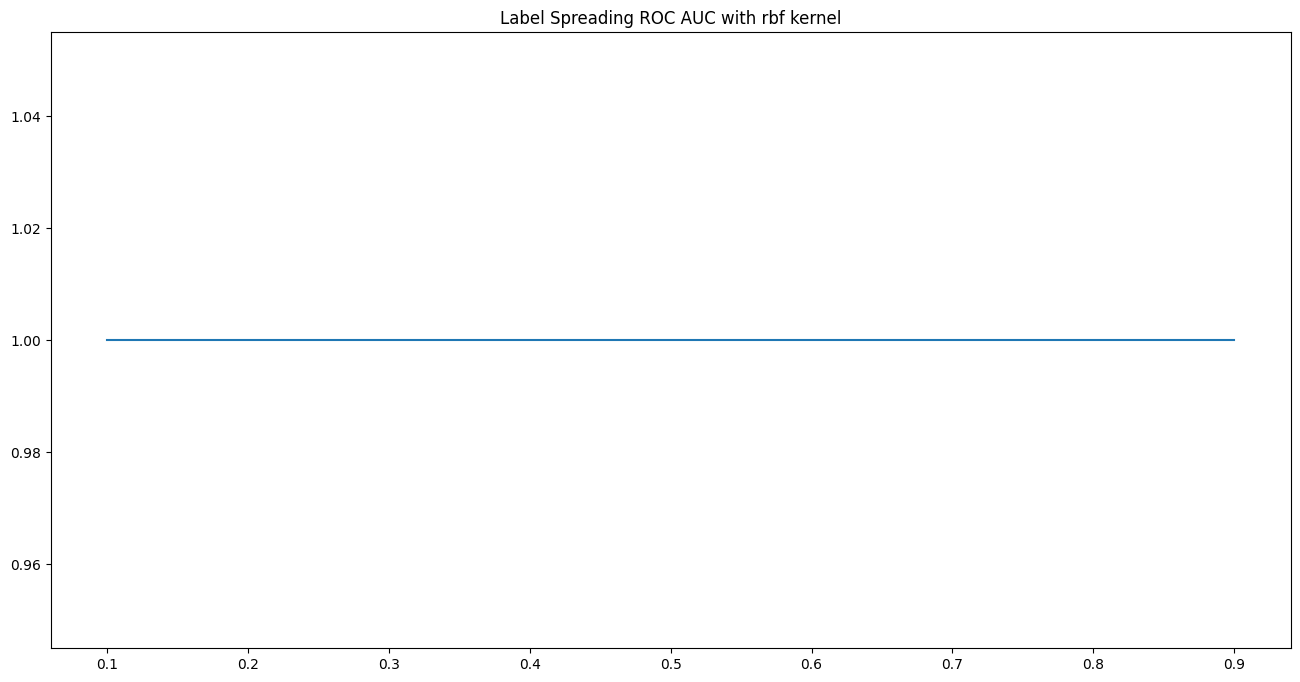

Best metrics value is at 0.1


In [13]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  
model_development.labels_spread_test('rbf', 40, alphas, x_train_embeddings, x_test_embeddings, y_train, y_test)

<Figure size 2000x1000 with 0 Axes>

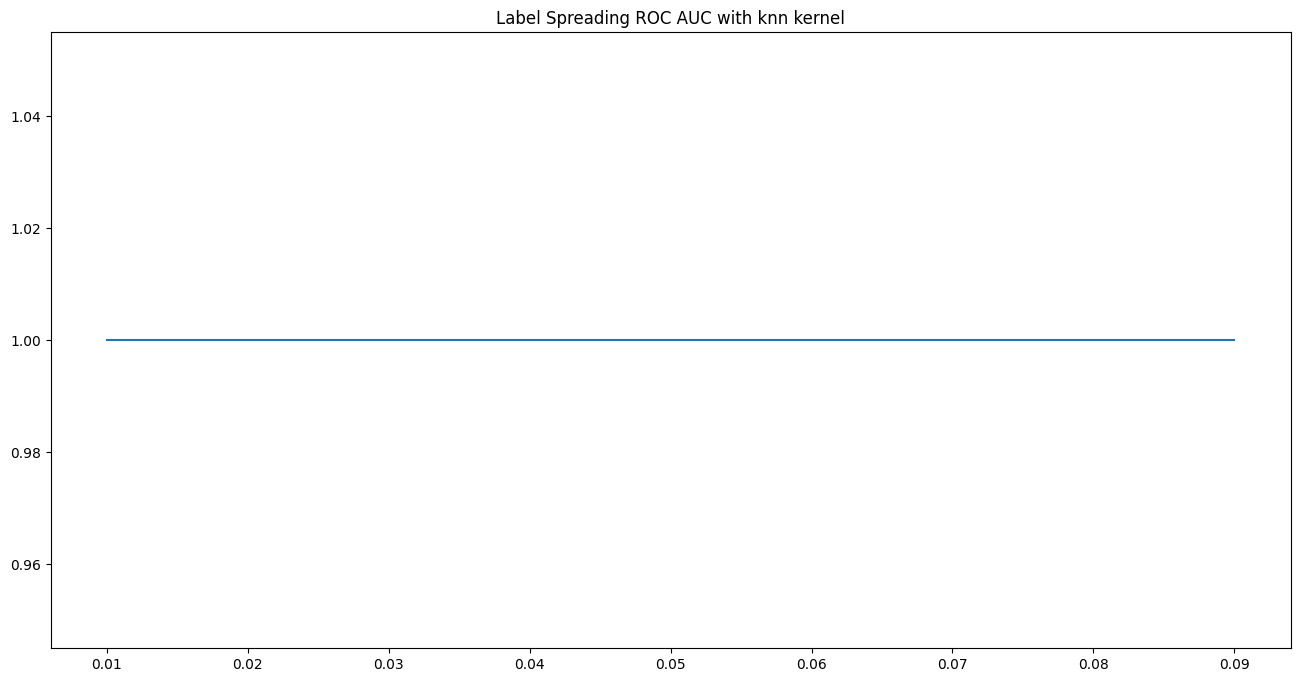

Best metrics value is at 0.01


In [15]:
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]  
model_development.labels_spread_test('knn', 28, alphas, x_train_embeddings, x_test_embeddings, y_train, y_test)

In [16]:
ls_rbf = LabelSpreading(kernel='rbf', gamma=40, alpha=0.1, max_iter=1000, tol=0.001)
ls_rbf.fit(x_train_embeddings, y_train)
results.loc[results.shape[0]]=['Label Spreading RBF', 
        roc_auc_score(y_test, ls_rbf.predict_proba(x_test_embeddings)[:,1])]
ls_knn = LabelSpreading(kernel='knn', n_neighbors=28, alpha=0.06, max_iter=1000, tol=0.001)
ls_knn.fit(x_train_embeddings, y_train)
results.loc[results.shape[0]]=['Label Spreading KNN', 
        roc_auc_score(y_test, ls_knn.predict_proba(x_test_embeddings)[:,1])]
results

,Algorithm,ROC AUC
0,Logistic Regression,1.0
1,Label Spreading RBF,1.0
2,Label Spreading KNN,1.0


<Figure size 2000x1000 with 0 Axes>

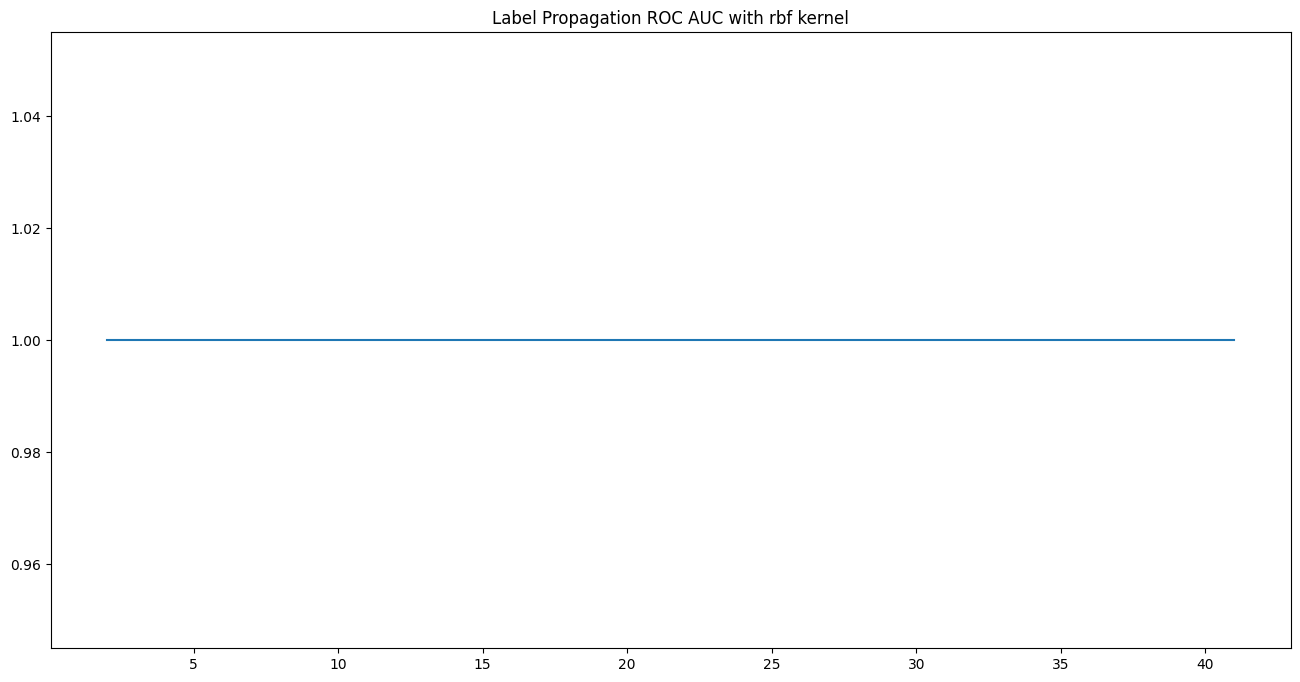

Best metrics value is at 2


In [17]:
gammas = np.arange(2,42)
model_development.label_prop_test('rbf', gammas, x_train_embeddings, x_test_embeddings, y_train, y_test)

<Figure size 2000x1000 with 0 Axes>

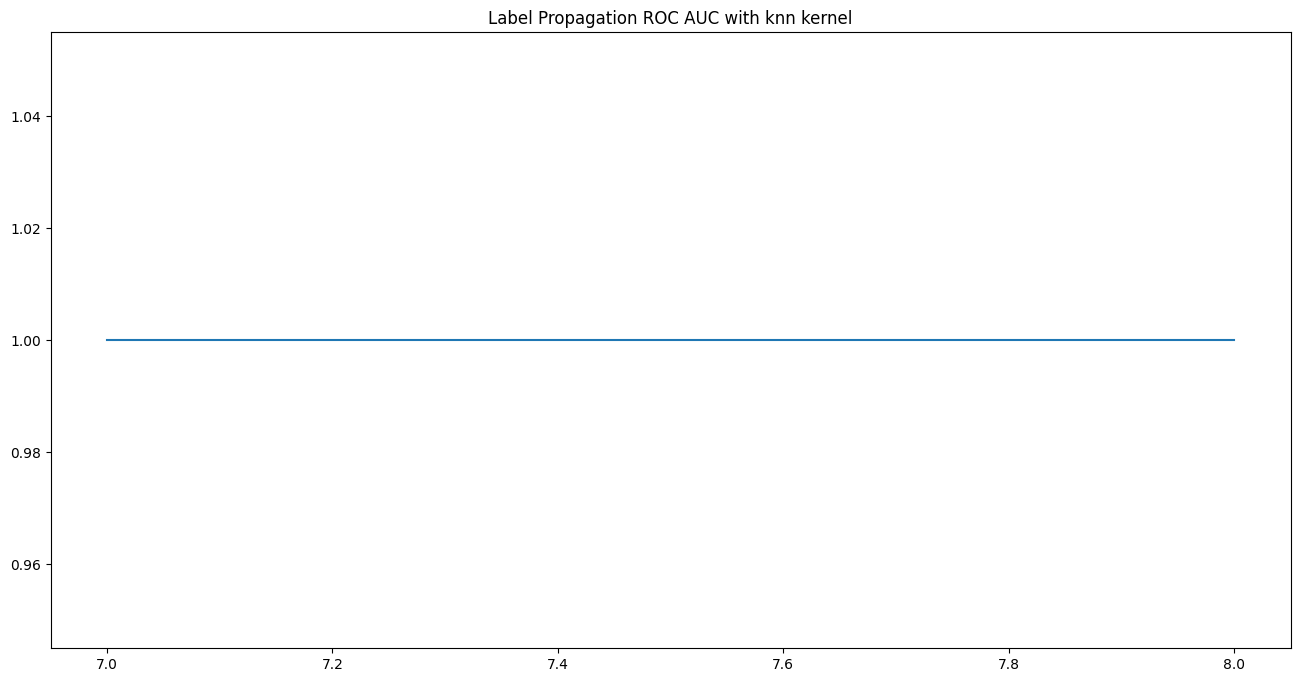

Best metrics value is at 7


In [20]:
ns = np.arange(30,60)
model_development.label_prop_test('knn', ns, x_train_embeddings, x_test_embeddings, y_train, y_test)

In [21]:
lp_rbf = LabelPropagation(kernel='rbf', gamma=29, max_iter=100000, tol=0.0001)
lp_rbf.fit(x_train_embeddings, y_train)
results.loc[results.shape[0]] = ['Label Propagation RBF', 
        roc_auc_score(y_test, lp_rbf.predict_proba(x_test_embeddings)[:,1])]
lp_knn = LabelPropagation(kernel='knn', n_neighbors=33, max_iter=100000, tol=0.0001)
lp_knn.fit(x_train_embeddings, y_train)
results.loc[results.shape[0]] = ['Label Propagation KNN', 
        roc_auc_score(y_test, lp_knn.predict_proba(x_test_embeddings)[:,1])]
results

,Algorithm,ROC AUC
0,Logistic Regression,1.0
1,Label Spreading RBF,1.0
2,Label Spreading KNN,1.0
3,Label Propagation RBF,1.0
4,Label Propagation KNN,1.0


* Results with ChatGPT Opinion

In [22]:
x_embeddings_with_ChatGPT=pd.read_csv(embeddings_with_ChatGPT_path,index_col=0)
x_train_labled_embeddings_with_ChatGPT,x_train_unlabled_embeddings_with_ChatGPT=x_embeddings_with_ChatGPT.loc[x_train_labled.index],x_embeddings_with_ChatGPT.loc[x_train_unlabled.index]
x_train_embeddings_with_ChatGPT=x_embeddings_with_ChatGPT.loc[x_train.index]
x_test_embeddings_with_ChatGPT=x_embeddings_with_ChatGPT.loc[x_test.index]

In [296]:
index = ['Algorithm', 'ROC AUC']
results_with_ChatGPT = pd.DataFrame(columns=index)

In [291]:
logreg_with_ChatGPT = LogisticRegression(random_state=1, class_weight='balanced')
logreg_with_ChatGPT.fit(x_train_labled_embeddings_with_ChatGPT, y_train_labled)

LogisticRegression(class_weight='balanced', random_state=1)

In [297]:
results_with_ChatGPT.loc[results_with_ChatGPT.shape[0]]=['Logistic Regression',\
         roc_auc_score(y_test, logreg_with_ChatGPT.predict_proba(x_test_embeddings_with_ChatGPT)[:,1])]
results_with_ChatGPT

,Algorithm,ROC AUC
0,Logistic Regression,0.842164


<Figure size 2000x1000 with 0 Axes>

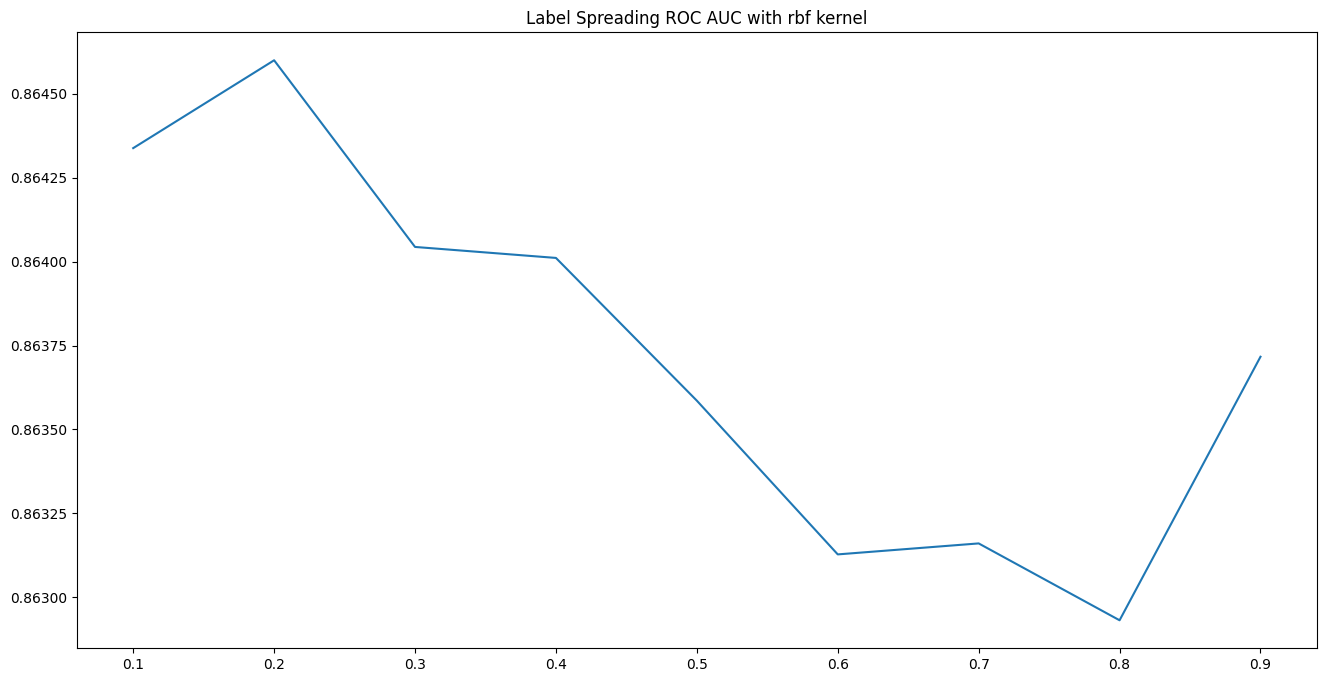

Best metrics value is at 0.2


In [298]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
model_development.labels_spread_test('rbf', 48, alphas, x_train_embeddings_with_ChatGPT, x_test_embeddings_with_ChatGPT, y_train, y_test)

<Figure size 2000x1000 with 0 Axes>

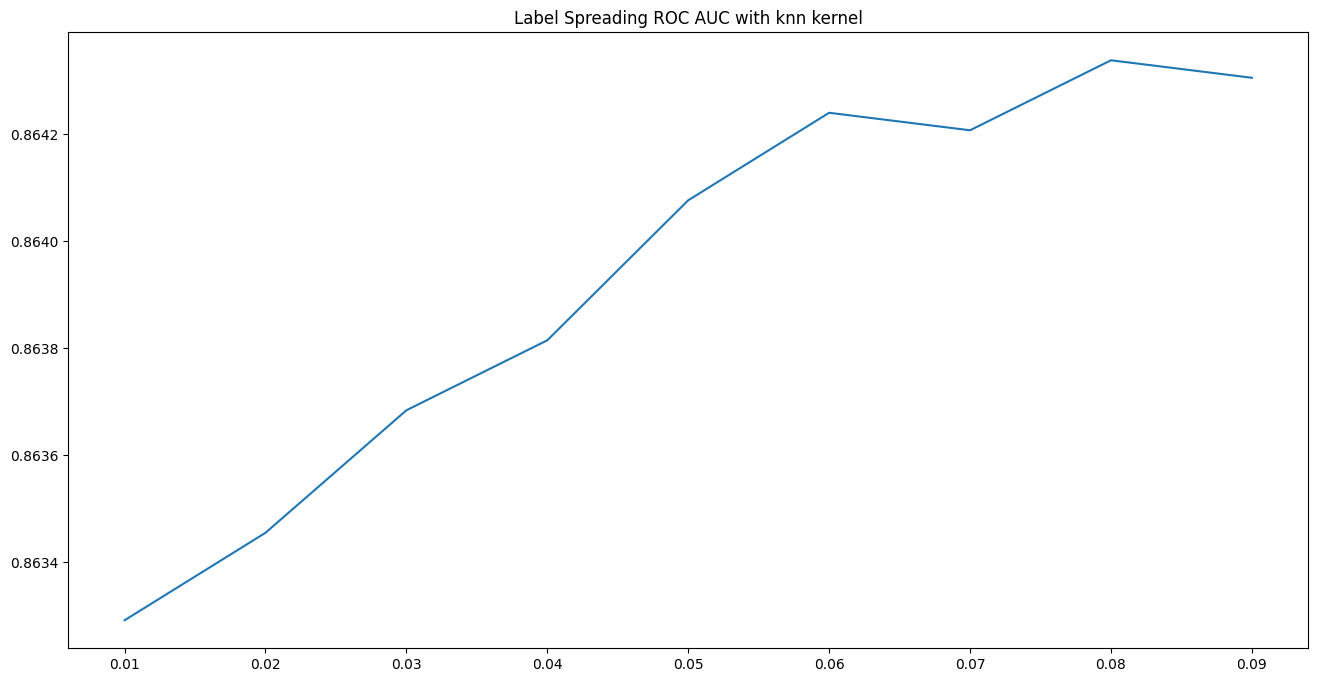

Best metrics value is at 0.08


In [299]:
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]  
model_development.labels_spread_test('knn', 15, alphas, x_train_embeddings_with_ChatGPT, x_test_embeddings_with_ChatGPT, y_train, y_test)

In [300]:
ls_rbf_with_ChatGPT = LabelSpreading(kernel='rbf', gamma=48, alpha=0.2, max_iter=1000, tol=0.001)
ls_rbf_with_ChatGPT.fit(x_train_embeddings_with_ChatGPT, y_train)
results_with_ChatGPT.loc[results_with_ChatGPT.shape[0]]=['Label Spreading RBF', 
        roc_auc_score(y_test, ls_rbf_with_ChatGPT.predict_proba(x_test_embeddings_with_ChatGPT)[:,1])]
ls_knn_with_ChatGPT = LabelSpreading(kernel='knn', n_neighbors=15, alpha=0.08, max_iter=1000, tol=0.001)
ls_knn_with_ChatGPT.fit(x_train_embeddings_with_ChatGPT, y_train)
results_with_ChatGPT.loc[results_with_ChatGPT.shape[0]]=['Label Spreading KNN', 
        roc_auc_score(y_test, ls_knn_with_ChatGPT.predict_proba(x_test_embeddings_with_ChatGPT)[:,1])]
results_with_ChatGPT

,Algorithm,ROC AUC
0,Logistic Regression,0.842164
1,Label Spreading RBF,0.864600
2,Label Spreading KNN,0.864338


* Only ChatGPT Opinion

In [23]:
x_embeddings_only_ChatGPT=pd.read_csv(embeddings_only_ChatGPT_path,index_col=0)
x_train_labled_embeddings_only_ChatGPT,x_train_unlabled_embeddings_only_ChatGPT=x_embeddings_only_ChatGPT.loc[x_train_labled.index],x_embeddings_only_ChatGPT.loc[x_train_unlabled.index]
x_train_embeddings_only_ChatGPT=x_embeddings_only_ChatGPT.loc[x_train.index]
x_test_embeddings_only_ChatGPT=x_embeddings_only_ChatGPT.loc[x_test.index]

In [306]:
index = ['Algorithm', 'ROC AUC']
results_only_ChatGPT = pd.DataFrame(columns=index)

In [304]:
logreg_only_ChatGPT = LogisticRegression(random_state=1, class_weight='balanced')
logreg_only_ChatGPT.fit(x_train_labled_embeddings_only_ChatGPT, y_train_labled)

LogisticRegression(class_weight='balanced', random_state=1)

In [307]:
results_only_ChatGPT.loc[results_only_ChatGPT.shape[0]]=['Logistic Regression',\
         roc_auc_score(y_test, logreg_only_ChatGPT.predict_proba(x_test_embeddings_only_ChatGPT)[:,1])]
results_only_ChatGPT

,Algorithm,ROC AUC
0,Logistic Regression,0.840038


<Figure size 2000x1000 with 0 Axes>

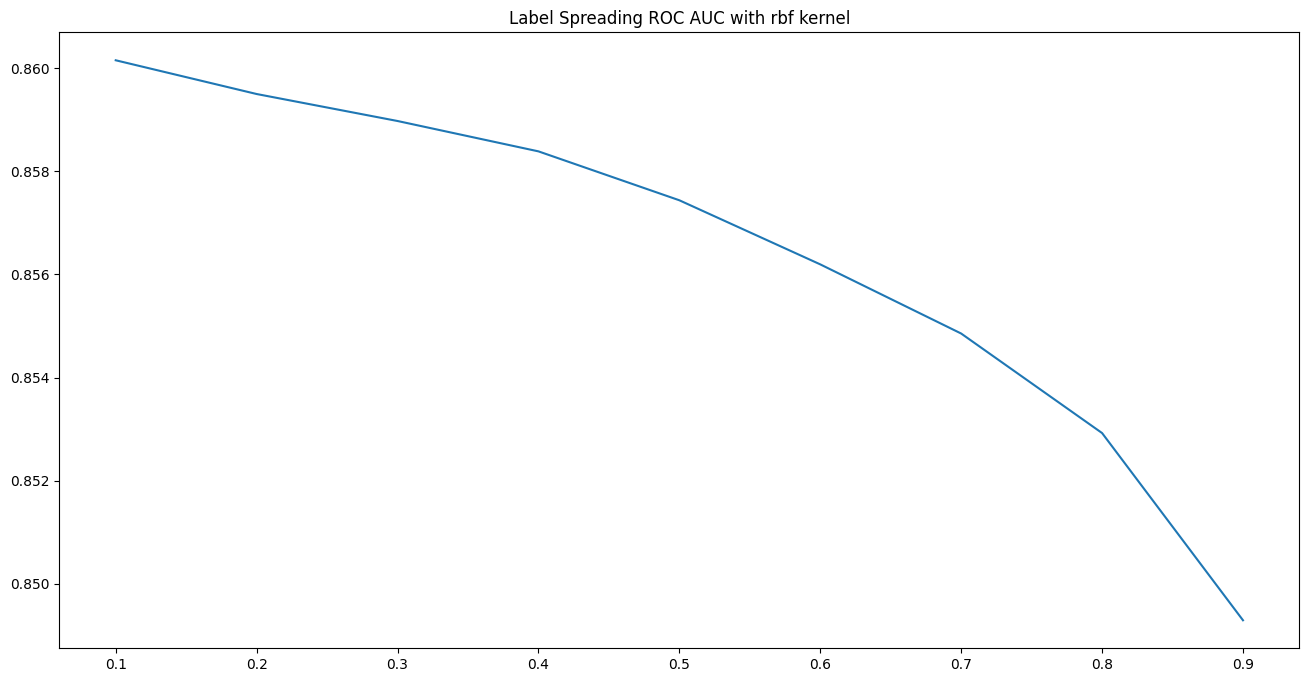

Best metrics value is at 0.1


In [319]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
model_development.labels_spread_test('rbf', 55, alphas, x_train_embeddings_only_ChatGPT, x_test_embeddings_only_ChatGPT, y_train, y_test)

<Figure size 2000x1000 with 0 Axes>

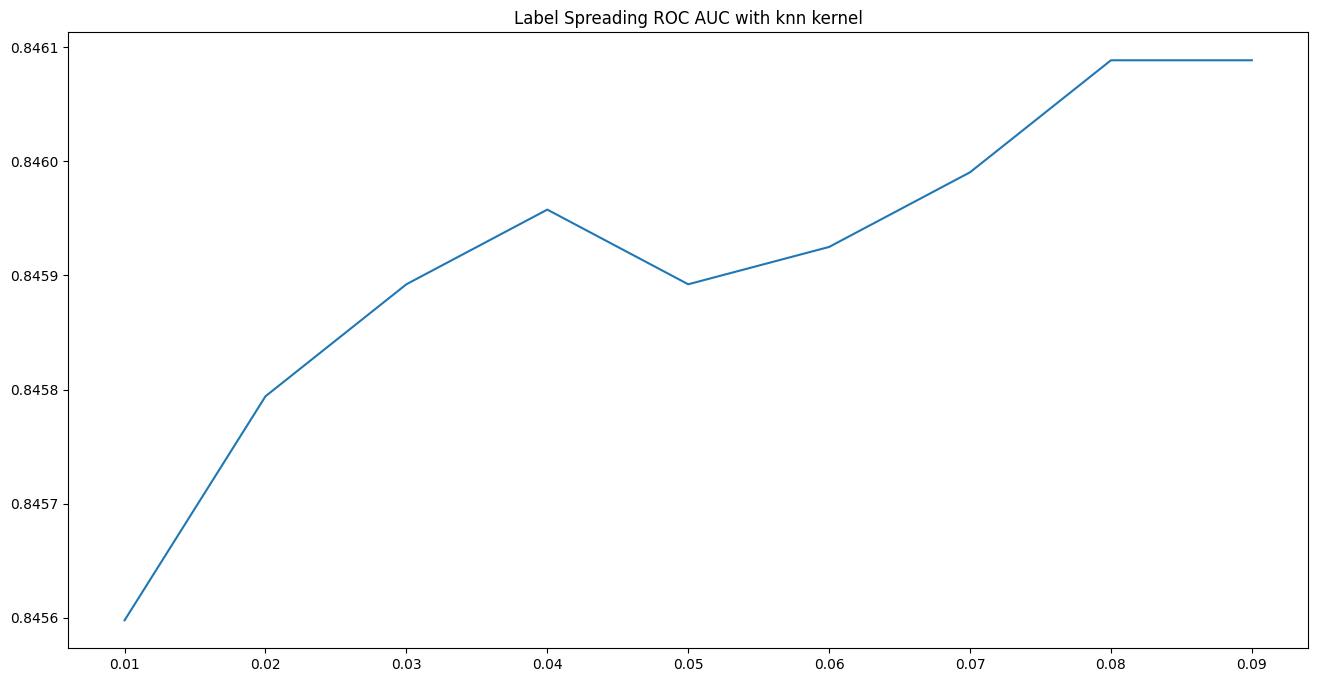

Best metrics value is at 0.09


In [324]:
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]  
model_development.labels_spread_test('knn', 35, alphas, x_train_embeddings_only_ChatGPT, x_test_embeddings_only_ChatGPT, y_train, y_test)

In [320]:
ls_rbf_only_ChatGPT = LabelSpreading(kernel='rbf', gamma=55, alpha=0.1, max_iter=1000, tol=0.001)
ls_rbf_only_ChatGPT.fit(x_train_embeddings_only_ChatGPT, y_train)
results_only_ChatGPT.loc[results_only_ChatGPT.shape[0]]=['Label Spreading RBF', 
        roc_auc_score(y_test, ls_rbf_only_ChatGPT.predict_proba(x_test_embeddings_only_ChatGPT)[:,1])]
ls_knn_only_ChatGPT = LabelSpreading(kernel='knn', n_neighbors=35, alpha=0.08, max_iter=1000, tol=0.001)
ls_knn_only_ChatGPT.fit(x_train_embeddings_only_ChatGPT, y_train)
results_only_ChatGPT.loc[results_only_ChatGPT.shape[0]]=['Label Spreading KNN', 
        roc_auc_score(y_test, ls_knn_only_ChatGPT.predict_proba(x_test_embeddings_only_ChatGPT)[:,1])]
results_only_ChatGPT

,Algorithm,ROC AUC
0,Logistic Regression,0.840038
1,Label Spreading RBF,0.860152
2,Label Spreading KNN,0.846088


In [337]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le_train,le_test=LabelEncoder(),LabelEncoder()
y_train_xgb,y_test_xgb=le_train.fit_transform(y_train_labled),le_test.fit_transform(y_test)
xgbmodel = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgbmodel.fit(x_train_labled_embeddings_with_ChatGPT, y_train_xgb)
preds = xgbmodel.predict(x_test_embeddings_with_ChatGPT)
roc_auc_score(y_test_xgb, preds)

0.7527472527472526

In [341]:
import pickle
pickle.dump(ls_rbf_with_ChatGPT,open(\
    './bucket/model_export_iphone6/label_spread_rbf_with_ChatGPT.sav','wb'))
pickle.dump(ls_rbf_only_ChatGPT,open(\
    './bucket/model_export_iphone6/label_spread_rbf_only_ChatGPT.sav','wb'))
pickle.dump(ls_knn_with_ChatGPT,open(\
    './bucket/model_export_iphone6/label_spread_knn_with_ChatGPT.sav','wb'))
pickle.dump(ls_knn_only_ChatGPT,open(\
    './bucket/model_export_iphone6/label_spread_knn_only_ChatGPT.sav','wb'))
pickle.dump(ls_rbf,open(\
    './bucket/model_export_iphone6/label_spread_rbf.sav','wb'))
pickle.dump(ls_knn,open(\
    './bucket/model_export_iphone6/label_spread_knn.sav','wb'))
pickle.dump(lp_rbf,open(\
    './bucket/model_export_iphone6/label_propagation_rbf.sav','wb'))
pickle.dump(lp_knn,open(\
    './bucket/model_export_iphone6/label_propagation_knn.sav','wb'))
pickle.dump(logreg_with_ChatGPT,open(\
    './bucket/model_export_iphone6/logreg_with_ChatGPT.sav','wb'))
pickle.dump(logreg_only_ChatGPT,open(\
    './bucket/model_export_iphone6/logreg_only_ChatGPT.sav','wb'))
pickle.dump(logreg,open(\
    './bucket/model_export_iphone6/logreg.sav','wb'))

* Test Model with actual tweets.

In [ ]:
# os.environ['bearer_token']=

In [ ]:
# bearer_token=os.environ.get('bearer_token')
# openai.api_key= bearer_token

In [ ]:
# import pickle
# loaded_model=pickle.load(open('./bucket/model_export_iphone6/label_spread_rbf_with_ChatGPT.sav','rb'))
# term='How to fix Netflix app that keeps crashing, doesn’t load properly on Apple iPhone XS'
# txt2vec=openai.Embedding.create(
#     model="text-embedding-ada-002",
#     input=term
# )
# emb= txt2vec['data'][0]['embedding']
# result = loaded_model.predict([emb])
# result